# Hyperplane Disk Density $f_{\nu}(x) = \exp(-||x||^2 - (\sum_{i=1}^d x_i)^2)$
Density that is concentrated around a zero-centered disk of a hyperplane, i.e. a (d-1)-dimensional subspace. 

In [1]:
import slice_sampling as ss
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg

In [2]:
# Set parameters
d = 200 # dimension, should be > 1
itnum = int(1e4) # number of chain iterations
path_prefix = "../plots/hyperplane_disk_"

In [3]:
log_density = lambda x: -alg.norm(x)**2 - np.sum(x)**2

In [4]:
# initialize chains in an area of high probability mass to avoid burn-in
x_0 = np.ones(d)
x_0[-1] = 1-d
x_0 *= 10.0 / alg.norm(x_0) # WARNING: the 10.0 is hand-adjusted to dim d=200, for d=100 it should be 7.0

In [5]:
w = 20.0 # WARNING: also hand-adjusted to dim d=200

In [6]:
samples_gpss = ss.gibbsian_polar_ss(log_density, x_0, w, itnum)

In [7]:
samples_hruss = ss.hit_and_run_uniform_ss(log_density, x_0, w, itnum)

In [8]:
samples_ess_u = ss.naive_elliptical_ss(log_density, x_0, itnum)

In [9]:
# compute empirical covariance to feed to ESS for tuned performance
from sklearn.covariance import EmpiricalCovariance
tuned_cov = EmpiricalCovariance().fit(samples_gpss).covariance_
print(tuned_cov[0,0], np.sum(tuned_cov[0,1:]))

0.513297738054733 -0.5096024123939613


In [10]:
# near-perfectly tuned ESS
log_likelihood = lambda x: -ss.log_prior(tuned_cov, x) + log_density(x)
samples_ess_t = ss.elliptical_ss(tuned_cov, log_likelihood, x_0, itnum)

In [11]:
snames = ["Gibbsian Polar S.S.", "Hit-and-Run Uniform S.S.", "Untuned Elliptical S.S.", "Tuned Elliptical S.S."]
samples = [samples_gpss, samples_hruss, samples_ess_u, samples_ess_t]
msamples = [sams[:,0] for sams in samples]
radii = [alg.norm(sams, axis=1) for sams in samples]
steps = [alg.norm(sams[1:] - sams[:-1], axis=1) for sams in samples]

In [12]:
print("Mean Step Sizes:")
for name, stps in zip(snames, steps):
    print("{:.2f}  {}".format(np.mean(stps), name))

Mean Step Sizes:
5.06  Gibbsian Polar S.S.
0.60  Hit-and-Run Uniform S.S.
2.57  Untuned Elliptical S.S.
3.21  Tuned Elliptical S.S.


Note: Due to the light tails in this version, the probability mass is actually concentrated on a fairly small region, so that step sizes are necessarily relatively small.

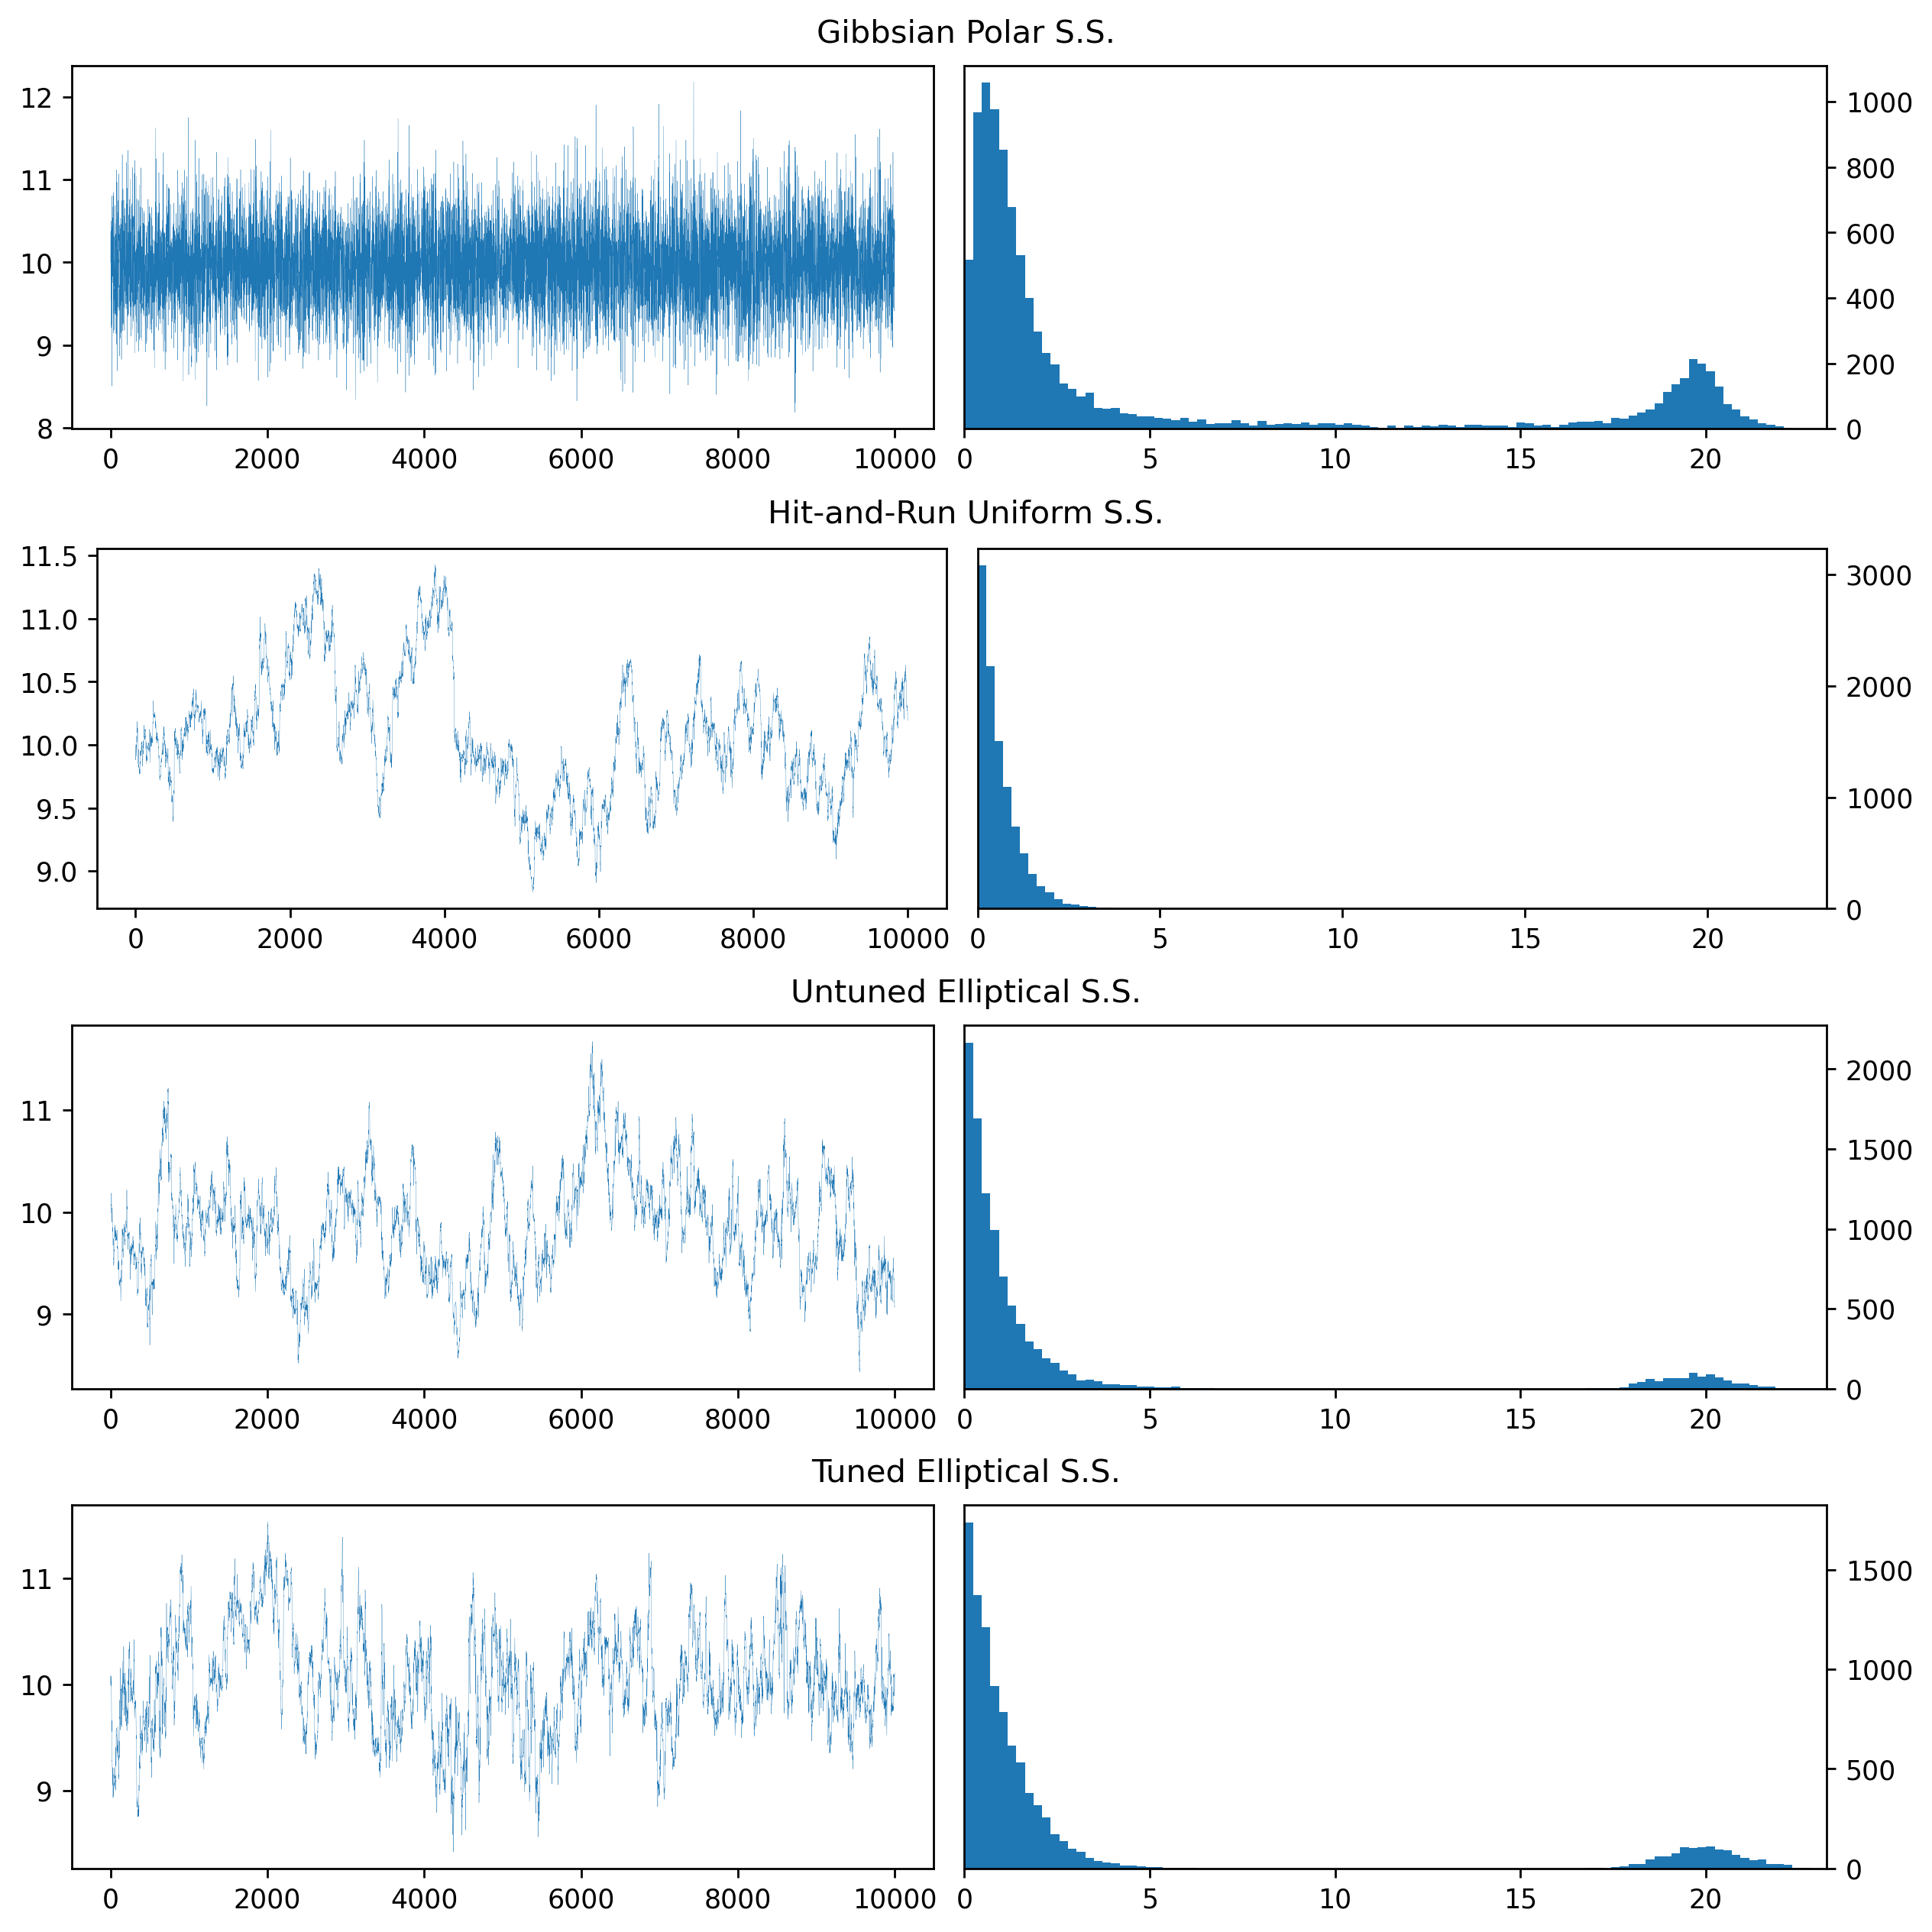

In [13]:
pfs.plot_trace_and_step_hists(radii, steps, snames, dpi=250, filepath = path_prefix + "radii_and_steps.png")